In [5]:
test_try_n=1

In [6]:
import torch
import os
from torch import nn
import json
# import time

test_path='./process_data/result5/'
os.listdir('./try'+str(test_try_n)+'_result/')

# ['DNS', 'LDAP', 'MSSQL', 'NetBIOS', 'NTP', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDPLag', 'UDP']

['Krum_3-D0']

In [7]:
temp_find = False
for temp_fn in os.listdir('./try'+str(test_try_n)+'_result/'):
    temp_w='./try'+str(test_try_n)+'_result/'+temp_fn+'/'
    if os.listdir(temp_w) == ['model.pt']:
        temp_find =True
        e_name=temp_fn
        break
if not temp_find:
    assert False

In [8]:
class TabTransformNet(nn.Module):
    def __init__(self):
        super(TabTransformNet, self).__init__()
        self.net=nn.Sequential(
            # nn.Linear(79, 64,bias=False),
            nn.Linear(66, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Linear(32, 66),
        )

    def forward(self, x):
        out = self.net(x)
        return out

class NeuTraL(nn.Module):
    def __init__(self, num_trans):
        super(NeuTraL, self).__init__()
        self.enc=nn.Sequential(
            nn.Linear(66, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
        )
        self.num_trans=num_trans
        self.trans = nn.ModuleList([TabTransformNet() for _ in range(self.num_trans)])

    def forward(self,x):
        x_T = torch.zeros(x.shape[0],self.num_trans,x.shape[-1]).to(x)
        for i in range(self.num_trans):
            mask = self.trans[i](x)
            mask = torch.sigmoid(mask)
            x_T[:, i] = mask * x
        x_cat = torch.cat([x.unsqueeze(1),x_T],1)  # x_cat形状为[batch_size,self.num_trans+1,79]
        zs = self.enc(x_cat.reshape(-1,x.shape[-1]))
        z_dim=zs.shape[-1]
        return zs.reshape(x.shape[0],self.num_trans+1,z_dim)

In [9]:
def NeuTraL_loss(z,device,y,temp=0.1):
    z=z.to(device)
    z = nn.functional.normalize(z, p=2, dim=-1)
    # 上面这一行 z本来形状为[batch_size,num_trans+1,z_dim] 处理后 每个z[a,b,:]向量都分别被变为长度为1
    
    z_ori = z[:, 0]  # n,z
    z_trans = z[:, 1:]  # n,k-1, z
    batch_size, num_trans, z_dim = z.shape  # 此处的num_trans实际上是num_trans+1

    sim_matrix = torch.exp(torch.matmul(z, z.permute(0, 2, 1) / temp))  # n,k,k
    
    # 下面这一行 减号前的一项形状为[batch_size,num_trans+1,z_dim] 减号后的一项形状为[1,num_trans+1,z_dim]
    # torch.eye()对角矩阵
    mask = (torch.ones_like(sim_matrix).to(device) - torch.eye(num_trans).unsqueeze(0).to(device)).bool()
    # 下面这一行 masked_select返回一维tensor
    sim_matrix = sim_matrix.masked_select(mask).view(batch_size, num_trans, -1)
    trans_matrix = sim_matrix[:, 1:].sum(-1)  # n,k-1

    pos_sim = torch.exp(torch.sum(z_trans * z_ori.unsqueeze(1), -1) / temp) # n,k-1
    K = num_trans - 1
    scale = 1 / abs(K*float(torch.log(torch.tensor(1.0 / K))))

    # loss_tensor = (torch.log(trans_matrix+1e-7) - torch.log(pos_sim+1e-7)) * scale
    p_k=pos_sim/(trans_matrix+1e-7) # n,k-1
    # y原本的形状是[n]
    y=y.view(-1,1)
    p_k_y=(1-y)*p_k+y*(1-p_k)
    l_tensor =-torch.log(p_k_y+1e-7)
    return l_tensor.sum(1)

def e_loss(x,net,device):
    # 测试时 仅使用损失函数的一项 需要传输全为0的y作为参数
    y=torch.zeros(x.shape[0]).float()
    y=y.to(device)
    net = net.to(device)
    x=x.to(device)
    with torch.no_grad():
        z=net(x)
        l=NeuTraL_loss(z,device,y)
    return l

In [10]:
t_num=4
model = NeuTraL(t_num)
model.load_state_dict(torch.load('./try'+str(test_try_n)+'_result/'+e_name+'/model.pt'))

# mean_std = json.load(open("./../dataset/Spotting_Anomalies_at_the_Edge/tensor/mean_std.json", 'r'))
batch_num=2000

C:\Users\riven\AppData\Local\Temp\ipykernel_18556\3704522685.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./try'+str(test_try_n)+'_r

In [11]:
dic={}

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for ff in ['attack_test/DNS.pt', 'attack_test/LDAP.pt', 'attack_test/MSSQL.pt', 'attack_test/NetBIOS.pt',
           'attack_test/NTP.pt', 'attack_test/Portmap.pt', 'attack_test/SNMP.pt', 'attack_test/SSDP.pt',
           'attack_test/Syn.pt', 'attack_test/TFTP.pt', 'attack_test/UDP.pt', 'attack_test/UDPLag.pt','BENIGN/BENIGN_test.pt']:
    
    test_data = torch.load(test_path+ff)
    print(ff)
    dic[ff]=[]
    i=0
    while i<test_data.shape[0]:
        data_x=test_data[i:min(i+batch_num,test_data.shape[0])]
        num_this_batch=data_x.shape[0]
        dic[ff].append(e_loss(data_x.to(device),model,device))
        i+=batch_num

C:\Users\riven\AppData\Local\Temp\ipykernel_18556\1952268231.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load(test_path+ff)


attack_test/DNS.pt
attack_test/LDAP.pt
attack_test/MSSQL.pt
attack_test/NetBIOS.pt
attack_test/NTP.pt
attack_test/Portmap.pt
attack_test/SNMP.pt
attack_test/SSDP.pt
attack_test/Syn.pt
attack_test/TFTP.pt
attack_test/UDP.pt
attack_test/UDPLag.pt
BENIGN/BENIGN_test.pt


In [12]:
dic_re={}
for k in dic.keys():
    if 'BENIGN' in k:
        k_re='BENIGN'
    else:
        k_re=k.split('/')[1][:-3]
    dic_re[k_re]=[]
    print(k_re)

    for tup in dic[k]:
        for i in range(tup.shape[0]):
            dic_re[k_re].append(float(tup[i]))

json.dump(dic_re, open("./try"+str(test_try_n)+"_result/"+e_name+"/score.json","w"))

DNS
LDAP
MSSQL
NetBIOS
NTP
Portmap
SNMP
SSDP
Syn
TFTP
UDP
UDPLag
BENIGN


In [13]:
import json
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

DNS 100000 40328
0.9982756369024002
LDAP 100000 40328
0.9985343808272169
MSSQL 100000 40328
0.9984082672088872
NetBIOS 100000 40328
0.9963858350277723
NTP 100000 40328
0.9981809060702241
Portmap 100000 40328
0.9963091308768102
SNMP 100000 40328
0.9985179525391787
SSDP 100000 40328
0.9986526055098195
Syn 100000 40328
0.8134293402846656
TFTP 100000 40328
0.9974840573546915
UDPLag 100000 40328
0.8611307383207697
UDP 100000 40328
0.9985950673229518
1200000 40328
0.9711586598537822


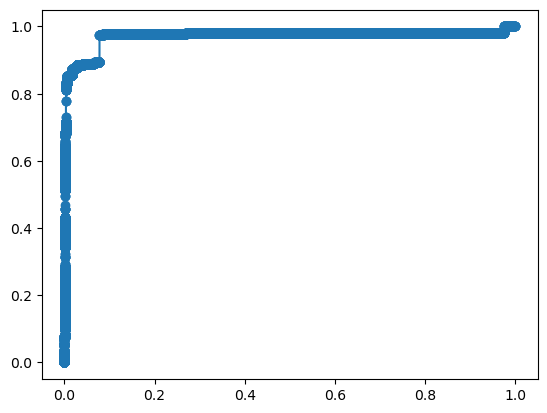

In [14]:
load_j = json.load(open("./try"+str(test_try_n)+"_result/"+e_name+"/score.json", 'r'))

for test_type in ['DNS', 'LDAP', 'MSSQL', 'NetBIOS', 'NTP', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDPLag', 'UDP']:
    p_num=len(load_j[test_type])
    n_num=len(load_j['BENIGN'])
    print(test_type,p_num,n_num)
    
    x_label=np.array([0]*n_num+[1]*p_num)
    x_score=np.array(load_j['BENIGN']+load_j[test_type])
    fpr, tpr, thresholds = metrics.roc_curve(x_label, x_score, pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    print(AUC)
    
    AUC_str="_AUC_%.6f"%AUC
    
    plt.clf()
    plt.plot(fpr,tpr,marker = 'o')
    plt.savefig("./try"+str(test_try_n)+"_result/"+e_name+"/"+test_type+AUC_str+".png")


p_num=0
for test_type in ['DNS', 'LDAP', 'MSSQL', 'NetBIOS', 'NTP', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDPLag', 'UDP']:
    p_num+=len(load_j[test_type])
n_num=len(load_j['BENIGN'])
print(p_num,n_num)
    
x_label=np.array([0]*n_num+[1]*p_num)
x_score=load_j['BENIGN']
for test_type in ['DNS', 'LDAP', 'MSSQL', 'NetBIOS', 'NTP', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDPLag', 'UDP']:
    x_score=x_score+load_j[test_type]
x_score=np.array(x_score)
fpr, tpr, thresholds = metrics.roc_curve(x_label, x_score, pos_label=1)
AUC = metrics.auc(fpr, tpr)
print(AUC)

AUC_str="zong_AUC_%.6f"%AUC
plt.clf()
plt.plot(fpr,tpr,marker = 'o')
plt.savefig("./try"+str(test_try_n)+"_result/"+e_name+"/"+AUC_str+".png")
plt.show()

In [15]:
print(e_name,AUC_str)

Krum_3-D0 zong_AUC_0.971159
